In [7]:
import os
import cv2
import numpy as np

### Copy imgs

In [29]:
DATA_DIR = 'data/'
DIR_ORG = DATA_DIR + 'v1.0.2/'
DIR_SYN = DATA_DIR + 'synthetic/origin/'

In [30]:
dirs = os.listdir(DIR_ORG)
dirs

['cccd_v1_back',
 'cccd_v1_front',
 'cccd_v2_back',
 'cccd_v2_front',
 'cmnd_v1_back',
 'cmnd_v1_front']

In [34]:
new_dirs = ['CitizenCardV1_back', 'CitizenCardV1_front', 'CitizenCardV2_back', 'CitizenCardV2_front', 'IdentificationCard_back', 'IdentificationCard_front']

In [40]:
import shutil

for j, dir in enumerate(dirs):
    src_dir = DIR_ORG + dir + '/images/part_1/'
    imgs = list(sorted(os.listdir(src_dir)))

    dst_dir = DIR_SYN + new_dirs[j] + '/'
    os.makedirs(dst_dir, exist_ok=True)
    
    i = 0
    while i < len(imgs):
        img_name = imgs[i].split('.')[0]
        img_name = '_'.join(p for p in img_name.split('_')[1:-1])
        if img_name.startswith('_'):
            img_name = '_'.join(p for p in img_name.split('_')[1:])
        
        if not os.path.exists(dst_dir + imgs[i]):
            shutil.copy(src_dir + imgs[i], dst_dir + img_name + '.png')
        i += 5

    print(f"{dir} : {len(imgs)} ---> {new_dirs[j]} : {len(os.listdir(dst_dir))}")



cccd_v1_back : 1925 ---> CitizenCardV1_back : 385
cccd_v1_front : 2000 ---> CitizenCardV1_front : 400
cccd_v2_back : 1700 ---> CitizenCardV2_back : 340
cccd_v2_front : 1965 ---> CitizenCardV2_front : 393
cmnd_v1_back : 1920 ---> IdentificationCard_back : 384
cmnd_v1_front : 1915 ---> IdentificationCard_front : 383


### Data Syntheis

In [3]:
DATA_DIR = 'data/synthetic/'
DIR_BG = DATA_DIR + 'background/'
DIR_ORG = DATA_DIR + 'origin/'
DIR_SYN = DATA_DIR + 'synthesis/'

In [4]:
dirs = os.listdir(DIR_ORG)
dirs

['CitizenCardV1_back',
 'CitizenCardV1_front',
 'CitizenCardV2_back',
 'CitizenCardV2_front',
 'IdentificationCard_back',
 'IdentificationCard_front']

In [ ]:
import cv2

def synthesis(img, dst_img):


    cv2.imread(src_img)

    cv2.

In [85]:
def get_params(width: int, height: int, distortion_scale: float):
    """Get parameters for ``perspective`` for a random perspective transform.

    Args:
        width (int): width of the image.
        height (int): height of the image.
        distortion_scale (float): argument to control the degree of distortion and ranges from 0 to 1.

    Returns:
        List containing [top-left, top-right, bottom-right, bottom-left] of the original image,
        List containing [top-left, top-right, bottom-right, bottom-left] of the transformed image.
    """
    half_height = height // 2
    half_width = width // 2
    topleft = np.array([
        int(np.random.randint(0, int(distortion_scale * half_width) + 1, size=(1,))),
        int(np.random.randint(0, int(distortion_scale * half_height) + 1, size=(1,))),
    ])
    topright = np.array([
        int(np.random.randint(width - int(distortion_scale * half_width) - 1, width, size=(1,))),
        int(np.random.randint(0, int(distortion_scale * half_height) + 1, size=(1,))),
    ])
    botright = np.array([
        int(np.random.randint(width - int(distortion_scale * half_width) - 1, width, size=(1,))),
        int(np.random.randint(height - int(distortion_scale * half_height) - 1, height, size=(1,))),
    ])
    botleft = np.array([
        int(np.random.randint(0, int(distortion_scale * half_width) + 1, size=(1,))),
        int(np.random.randint(height - int(distortion_scale * half_height) - 1, height, size=(1,))),
    ])
    startpoints = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')
    endpoints = np.array([topleft, topright, botright, botleft], dtype='float32')
    return startpoints, endpoints

In [21]:
import matplotlib.pyplot as plt

def show_cv_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.axis('off')


(480, 746, 3)
[[  9.  28.]
 [690.  18.]
 [714. 466.]
 [ 41. 467.]]
(480, 746, 3) (449, 705, 3)
[[ 9 18]]
[[  0.  10.]
 [681.   0.]
 [705. 448.]
 [ 32. 449.]]
643 386
[[544 619]]
[[ 643.  396.]
 [1324.  386.]
 [1348.  834.]
 [ 675.  835.]]


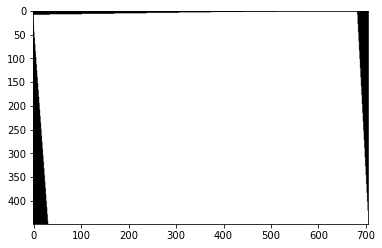

In [200]:

for dir in dirs:
    src_dir = DIR_ORG + dir + '/'
    dst_dir = DIR_SYN + dir + '/'
    os.makedirs(dst_dir, exist_ok=True)

    imgs_org = list(sorted(os.listdir(src_dir)))

    for img_name in imgs_org:
        
        img = cv2.imread(src_dir + img_name)

        # show_cv_img(img)
        print(img.shape)
        height, width = img.shape[:2]

        src, dst = get_params(width, height, distortion_scale=0.15)
        trans_mat = cv2.getPerspectiveTransform(src, dst)
        warp = cv2.warpPerspective(img, trans_mat, (width, height))
        # for corner in dst:
        #     cv2.circle(warp, tuple(map(int, corner)), radius=10, color=(0, 0, 255), thickness=-1)
        
        print(dst)
        mins = np.min(dst, axis=0)
        x_min, y_min = map(int, (mins[0], mins[1]))
        maxs = np.max(dst, axis=0)
        x_max, y_max = map(int, (maxs[0], maxs[1]))

        # print(x_min, y_min, x_max, y_max)
        cut = warp[y_min:y_max, x_min:x_max]

        print(warp.shape, cut.shape)

        # show_cv_img(warp)

        cut_height, cut_width = cut.shape[:2]
        # print(cut.shape)
        # diff = np.array([[height - cut_height, width - cut_width]])
        diff = np.array([[x_min, y_min]])
        print(diff)
        dst_cut = dst - diff
        print(dst_cut)
        # for corner in dst_cut:
        #     cv2.circle(cut, tuple(map(int, corner)), radius=10, color=(0, 0, 255), thickness=-1)
        
        mask_cut = np.zeros(cut.shape, np.uint8)        
        cv2.drawContours(mask_cut, [dst_cut.reshape((-1,1,2)).astype('int32')], -1, (255, 255, 255), -1)
        show_cv_img(mask_cut)

        bg = cv2.imread(DIR_BG + 'bg_0.jpeg')
        bg_org = bg.copy()
        # print(bg.shape)
        bg_height, bg_width = bg.shape[:2]

        # rand_x = np.random.randint(cut_width//2 + 1, bg_width - cut_width//2 - 1)
        # rand_y = np.random.randint(cut_height//2 + 1, bg_height - cut_height//2 - 1)
        # rand_center = (rand_x, rand_y)
        # print(rand_center)
        # cv2.circle(bg, rand_center, radius=10, color=(255, 0, 0), thickness=-1)

        # mask = np.zeros(cut.shape, cut.dtype)
        # cv2.fillPoly(mask, [dst.astype('int32')], (255, 255, 255))
        # clone = cv2.seamlessClone(cut, bg, mask, rand_center, cv2.NORMAL_CLONE)

        rand_x = np.random.randint(0, bg_width - cut_width - 1)
        rand_y = np.random.randint(0, bg_height - cut_height - 1)
        print(rand_x, rand_y)
        # cv2.circle(bg, (rand_x, rand_y), radius=10, color=(255, 0, 0), thickness=-1)      

        # bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width] = cut
        # show_cv_img(bg)
        # cv2.imwrite(DIR_SYN + 'test.png', bg)

        rand_start = np.array([[rand_x, rand_y]])
        diff = np.array([[bg_height - height, bg_width - width]], dtype='int32')
        print(diff)

        corners = rand_start + dst_cut # - diff
        print(corners)
        # for corner in corners:
        #     cv2.circle(bg, tuple(map(int, corner)), radius=10, color=(0, 0, 255), thickness=-1)
        # show_cv_img(bg)



        # show_cv_img(warp)
        
        fin_cut = cv2.cvtColor(cut, cv2.COLOR_RGB2RGBA)
        b, g, r, a = cv2.split(fin_cut)
        a = mask_cut
        fin_cut[:,:, 0] = cut[:,:,0]
        fin_cut[:,:, 1] = cut[:,:,1]
        fin_cut[:,:, 2] = cut[:,:,2]
        fin_cut[:,:, 3] = a[:,:,0]

        alpha_s = fin_cut[:, :, 3] / 255.
        alpha_l = 1. - alpha_s

        for c in range(0, 3):
            bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width, c] = (alpha_s * cut[:, :, c] +
                              alpha_l * bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width, c])

        mask_bg = np.zeros(bg.shape, dtype='uint8')
        mask_bg[rand_y:rand_y+cut_height, rand_x:rand_x+cut_width] = mask_cut
        #show_cv_img(mask_bg)

        alpha = cv2.GaussianBlur(mask_bg, (35, 35), 50).astype('float32') / 255.
        # show_cv_img(alpha)

        comp = alpha * bg.astype('float32') + (1 - alpha) * bg_org.astype('float32')
        # show_cv_img(comp.astype('uint8'))        

        cv2.circle(comp, (rand_x, rand_y), radius=5, color=(255, 0, 0), thickness=-1)
        cv2.rectangle(comp, (rand_x, rand_y), (rand_x+cut_width, rand_y+cut_height), (0, 255, 0))
        for corner in corners:
            cv2.circle(comp, tuple(map(int, corner)), radius=5, color=(0, 0, 255), thickness=-1)

        # show_cv_img(bg)
        cv2.imwrite(DIR_SYN + 'cut.png', comp)
        cv2.imwrite(DIR_SYN + 'mask_bg.png', mask_bg)
        cv2.imwrite(DIR_SYN + 'alpha.png', (alpha * 255.).astype('uint8'))

        break

    break